# Uncertainty assessment

The IPCC guidelines provide information on taking into account uncertainty.
The `bonsai_ipcc` package implements those by allowing the user to do analytical error propagation and Monte Carlo simualtion when running a tier sequence. 

To use one of the approaches, each parameter involved in a sequence requires information about its uncertainty. This information is specifeid by the properties "def" , "min", "max", "abs_min" and "abs_max" (mean, 2.5 percentile, 97.5 percentile, absolute minimum, absolute maximum) in the parameter table.

Let´s use have a look into the waste incineration example.

## Add data with uncertainty
As already done in the previous tutorial for running a sequence, we need to add the data which is not provided by the package. So let´s do this again.

In [1]:
import bonsai_ipcc
import pandas as pd
import numpy as np

my_ipcc = bonsai_ipcc.IPCC()

# urban population
d = {
    "year": [2010,2010,2010,2010,2010],
    "region": ["DE","DE","DE","DE","DE"],
    "property": [
        "def","min","max","abs_min","abs_max"
    ],
    "value": [
        62940432.0,61996325.52,63884538.48,0.0,np.inf,
    ],
    "unit": [
    "cap/yr","cap/yr","cap/yr","cap/yr","cap/yr",
    ],
}
urb_pop = pd.DataFrame(d).set_index(["year", "region", "property"])

my_ipcc.waste.incineration.parameter.urb_population=urb_pop

To take the uncertainty into account, we need to add the values for `def`, `min`, `max`, `abs_min`, and `abs_max`. A description of the `property` dimension can be found here:

In [2]:
my_ipcc.waste.incineration.dimension.property

,description,remarks
code,,
def,default,mean
min,minimum,2.5th percentile
max,maximum,97.5th percentile
abs_max,absolute maximun,theoretical upper bound
abs_min,absolute minimum,theoretical lower bound
dummy,place holder for emtpy tables,NaN


## Monte Carlo simulation

To run the sequence as Monte Carlo simulation you can use `monte_carlo` as keyword. Notably, the ipcc package uses a vectorized way of iplmenting Monte Carlo simulation. Thus, all parameters for those uncertainty information is included in the parameter tables and all calculated results are represented as numpy arrays (1000 values).

We use the incineration example again, but chose the paper fraction of municipal waste instead of plastics.

In [3]:


# run the sequence
my_tier = my_ipcc.waste.incineration.sequence.tier1_co2(year=2010, region="DE", wastetype= "msw_paper", incintype= "inc_unspecified", uncertainty="monte_carlo")
s = my_tier.to_dict()


2023-12-19 15:35:42,594 - INFO - Incineration sequence started --->
2023-12-19 15:35:42,595 - INFO - Uncertainty distribution for parameter 'urb_population':
2023-12-19 15:35:42,595 - INFO - lognormal distribution
/Users/TN76JP/Documents/coderefinery/ipcc/ipcc/src/ipcc/_sequence.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_c = conc_df.loc[c][j]
2023-12-19 15:35:42,598 - INFO - Uncertainty distribution for parameter 'msw_gen_rate':
2023-12-19 15:35:42,598 - INFO - lognormal distribution
2023-12-19 15:35:42,598 - INFO - 'Coordinates (2010, 'DE')' has been replaced by '[2006, 'Western Europe']' during reading parameter table 'msw_gen_rate'
2023-12-19 15:35:42,599 - INFO - Uncertainty distribution for parameter 'msw_frac_to_incin':
2023-12-19 15:35:42,600 - INFO - normal distribution, lower un

In [4]:
# check the last step (emissions)
type(s["co2_emissions"].value)

numpy.ndarray

### Plot the results

(array([119., 229., 228., 183., 107.,  63.,  41.,  20.,   3.,   7.]),
 array([1.02748936e-01, 2.78783377e+01, 5.56539265e+01, 8.34295153e+01,
        1.11205104e+02, 1.38980693e+02, 1.66756282e+02, 1.94531871e+02,
        2.22307459e+02, 2.50083048e+02, 2.77858637e+02]),
 <BarContainer object of 10 artists>)

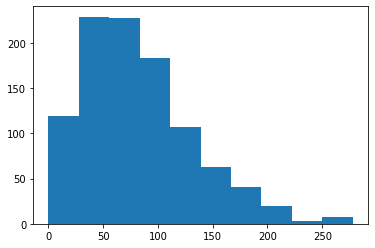

In [5]:
# plot the emissions
import matplotlib.pyplot as plt

plt.hist(my_tier.co2_emissions.value)

## Analytical error propagation

Another method that is implemented in the ipcc package is analytical error propgation. The keyword `analytical` can be used in this case. The implementation is done using the `uncertainties` Python package. Thus all results are of type `ufloat`.

In [6]:
final_step = my_ipcc.waste.incineration.sequence.tier1_co2(year=2010, region="DE", wastetype= "msw_paper", incintype= "inc_unspecified", uncertainty="analytical").co2_emissions
final_step

2023-12-19 15:35:43,008 - INFO - Incineration sequence started --->
/Users/TN76JP/Documents/coderefinery/ipcc/ipcc/src/ipcc/_sequence.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_c = conc_df.loc[c][j]
2023-12-19 15:35:43,010 - INFO - 'Coordinates (2010, 'DE')' has been replaced by '[2006, 'Western Europe']' during reading parameter table 'msw_gen_rate'
2023-12-19 15:35:43,011 - INFO - 'Coordinates (2010, 'DE')' has been replaced by '[2006, 'Western Europe']' during reading parameter table 'msw_frac_to_incin'
2023-12-19 15:35:43,013 - INFO - 'Coordinates (2010, 'DE', 'msw_paper')' has been replaced by '[2006, 'DE', 'msw_paper']' during reading parameter table 'msw_type_frac'
2023-12-19 15:35:43,015 - INFO - 'Coordinates (2010, 'DE', 'inc_unspecified')' has been replaced by '[2006, 'World', 

Step(position=12, year=2010, unit='Gg/year', value=88.4667825477414+/-52.63985799388056, type='elementary')

### Plot the results

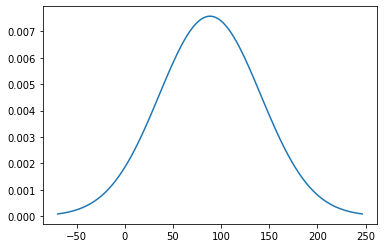

In [7]:
import scipy.stats as stats

mu = final_step.value.n
sigma = final_step.value.std_dev
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))

## What can we learn?

In this example, the values can be negative when using analytical error propagation. This is due to the high uncertainties in the data, using the tier 1 approach. However, it does not make sense to have negative CO2 emissions! Thus, Monte Carlo simulation should be used rather than analytical error propagation which is suitable for lower uncertainties.